In [1]:
import sys
sys.path.append("/home/fengchen/md4")

from md4.configs.md4.text8 import get_config
from collections.abc import Callable, Mapping, Sequence
import copy
import functools
from typing import Any


from absl import logging
from clu import metric_writers
from clu import metrics
from clu import parameter_overview
from clu import periodic_actions
from etils import epath
import flax
import flax.jax_utils as flax_utils
import flax.linen as nn
import grain.python as grain
import jax
from jax.experimental import checkify
import jax.numpy as jnp
import ml_collections
import numpy as np
import optax
from orbax import checkpoint as orbax_checkpoint

from md4 import input_pipeline
from md4 import input_pipeline_v2
from md4 import sampling
from md4 import utils
from md4.models import utils as model_utils

from md4.train import *
from md4.train import _get_checkpoint_manager

import pickle
from tqdm import tqdm

config = get_config()
workdir = "/home/fengchen/md4/md4/text8_base"

2025-05-14 04:21:11.920757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196471.943902   71383 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196471.951547   71383 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747196471.969585   71383 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196471.969608   71383 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196471.969610   71383 computation_placer.cc:177] computation placer alr

cv2 not found


In [2]:
config.vocab_dir='/home/fengchen/md4/md4/data_dir/text8/text8_vocab.pkl'

In [3]:
with open(config.vocab_dir, "rb") as f:
    vocab = pickle.load(f)

workdir = epath.Path(workdir)
workdir.mkdir(parents=True, exist_ok=True)

rng = utils.get_rng(config.seed)
logging.info("Using random seed %s.", rng)
writer = metric_writers.create_default_writer(
    workdir, just_logging=jax.process_index() > 0
)

# Learning rate schedule.
assert config.batch_size % jax.device_count() == 0
per_device_batch_size = config.batch_size // jax.device_count()
num_train_steps = input_pipeline.get_num_train_steps(config)
steps_per_epoch = num_train_steps // config.num_epochs
logging.info(
    "num_train_steps=%d, steps_per_epoch=%d", num_train_steps, steps_per_epoch
)

schedule_fn = functools.partial(
    get_learning_rate,
    base_learning_rate=config.learning_rate,
    num_steps=num_train_steps,
    warmup_steps=config.warmup_steps,
    schedule_type=config.learning_rate_schedule,
)

# Build input pipeline.
rng, data_seed = jax.random.split(rng)
data_seed = int(
    jax.random.randint(data_seed, [], minval=0, maxval=np.iinfo(np.int32).max)
)
# The input pipeline runs on each process and loads data for local TPUs.
create_datasets = (
    input_pipeline_v2.create_datasets
    if config.get("use_v2_input_pipeline", None)
    else input_pipeline.create_datasets
)
train_loader, eval_loaders, dataset_info = create_datasets(config, data_seed)
train_iter = iter(train_loader)
# Initialize model.
rng, model_rng = jax.random.split(rng)
data_shape = input_pipeline.get_data_shape(config)
# Note: parameters are initialized in half precision if mixed_precision_training=True
# We could also try casting them to half precision here
model, optimizer, train_state, metrics_class = (
    create_train_state(  # pylint: disable=invalid-name
        config,
        model_rng,
        input_shape=(per_device_batch_size // config.num_microbatches,)
        + data_shape,
        schedule_fn=schedule_fn,
    )
)
# # Set up checkpointing of the model and the input pipeline.
# checkpoint_manager = _get_checkpoint_manager(config, workdir)
# # Retrieve data from previous checkpoints if possible.
checkpointed_state = dict(train_state=train_state, 
    step=0
    # train_iter=train_iter
)

from clu import checkpoint
checkpoint_dir = str(workdir / "checkpoints")
# The vdm code initalizes two checkpoints, one for loading and one for saving
# which I don't understand
# ckpt = checkpoint.MultihostCheckpoint(checkpoint_dir)
ckpt = checkpoint.Checkpoint(checkpoint_dir, max_to_keep=10)
checkpoint_to_restore = ckpt.get_latest_checkpoint_to_restore_from()

if checkpoint_to_restore:
    checkpointed_state = ckpt.restore_or_initialize(checkpointed_state)
# state_restore_dict = ckpt.restore_dict(checkpoint_to_restore)
# checkpointed_state = restore_partial(checkpointed_state, state_restore_dict)
train_state = checkpointed_state["train_state"]

I0000 00:00:1747196481.529360   71383 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38361 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
I0000 00:00:1747196481.531565   71383 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38365 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:05.0, compute capability: 8.0
I0000 00:00:1747196481.535518   71383 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38365 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:06.0, compute capability: 8.0
I0000 00:00:1747196481.538092   71383 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38365 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:07.0, compute capability: 8.0
I0000 00:00:1747196481.540107   71383 gpu_device.cc:2019] Create

In [4]:
# We can't do flax serialization so long as we're using grain for the data loader
# train_iter = checkpointed_state["train_iter"]
# Distribute training.
train_state = flax_utils.replicate(train_state)
train_step_func = functools.partial(
    train_step,
    model=model,
    optimizer=optimizer,
    train_metrics_class=metrics_class,
    learning_rate_fn=schedule_fn,
    ema_rate=config.ema_rate,
    num_microbatches=config.get("num_microbatches", None),
)
if config.check_nans:
    train_step_func = checkify.checkify(
        train_step_func, errors=checkify.float_checks
    )
p_train_step = jax.pmap(train_step_func, axis_name="batch", donate_argnums=(0,))
p_eval_step = jax.pmap(
    functools.partial(
        eval_step,
        model=model,
        eval_metrics_class=metrics_class,
        ema_rate=config.ema_rate,
    ),
    axis_name="batch",
)
hooks = []
report_progress = periodic_actions.ReportProgress(
    num_train_steps=num_train_steps, writer=writer
)
if jax.process_index() == 0:
    hooks += [
        report_progress,
        periodic_actions.Profile(num_profile_steps=5, logdir=workdir),
    ]
train_metrics = None
# Unreplicating from TPU is costly, so we only do it once at the start.
# initial_step = int(flax.jax_utils.unreplicate(train_state.step))
initial_step = checkpointed_state["step"]
logging.info("Initial step is %d", initial_step)

In [5]:
batch = utils.reshape_batch(next(train_iter))

if config.check_nans:
    errs, (train_state, metrics_update) = p_train_step(
        train_state=train_state, batch=batch
    )
    errs.throw()
else:
    train_state, metrics_update = p_train_step(train_state=train_state, batch=batch)
metric_update = flax_utils.unreplicate(metrics_update)

train_metrics = (
    metric_update if train_metrics is None else train_metrics.merge(metric_update)
)

2025-05-14 04:21:52.419220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:21:52.422898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:21:52.434724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:21:52.434725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196512.442208   72817 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
batch_size 64
cv2 not found
cv2 not found
cv2 not found


In [6]:
model.sampler = "maskgit"

results_dict = {}

tem_range = [.5,1.0,2.0,4.0,8.0,10.0,12.0,16.0,20.0,40.0]

# for k in k_range:
#     for tem in tem_range:
#         results_dict[k, tem] = {}

# timesteps = 256
# model.timesteps = timesteps // 2

for tem in tqdm(tem_range):
    for timesteps in tqdm([16, 32, 64, 128, 256]):
        model.timesteps = timesteps
        model.maskgit_temp = tem
        # for timesteps in tqdm([16, 32, 64, 128, 256]):
        #     model.timesteps = timesteps
        # with report_progress.timed("sample"):
        _, sample_rng = jax.random.split(rng)
        dummy_loader = train_loader
        dummy_batch = utils.reshape_batch(next(iter(dummy_loader)))
        dummy_inputs = dummy_batch[config.task_type]
        if "label" in dummy_batch:
            conditioning = dummy_batch["label"].astype("int32")
        else:
            conditioning = None

        samples = sampling.generate(
            model,
            train_state,
            flax_utils.replicate(sample_rng),
            dummy_inputs,
            conditioning=conditioning,
        )

        all_samples = jax.pmap(
            lambda x: jax.lax.all_gather(x, "batch"), axis_name="batch"
        )(samples)
        all_samples = flax_utils.unreplicate(all_samples)
        all_samples = all_samples.reshape(-1, *data_shape)

        tokenizer = dataset_info["tokenizer"]
        texts = utils.detokenize_texts(all_samples, tokenizer)
        results_dict[timesteps, tem] = texts

  0%|          | 0/10 [00:00<?, ?it/s]2025-05-14 04:22:37.776667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:22:37.780846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:22:37.780848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:22:37.785448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196557.799216   76170 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory f

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:23:05.850185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196585.873241   79201 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196585.880863   79201 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:23:05.893827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:23:05.894334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:17471

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:23:26.699444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196606.722396   81495 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196606.729912   81495 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747196606.747681   81495 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196606.747735   81495 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196606.747738   81495 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:23:48.605078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:23:48.615351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196628.627822   83754 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196628.635288   83754 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747196628.637888   83755 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196628.645317   83755 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:24:13.877248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:24:13.877254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:24:13.894376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196653.899851   86078 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196653.899850   86085 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17471966

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 10%|█         | 1/10 [02:08<19:13, 128.21s/it]2025-05-14 04:24:46.029528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:24:46.031515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:24:46.050232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:24:46.050232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196686.052879   88312 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:25:05.413308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196705.436348   90611 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 04:25:05.443378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:25:05.443378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196705.443967   90611 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:25:

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:25:26.078063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:25:26.078178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:25:26.079984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196726.100356   92910 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196726.100733   92902 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 04:25:26.

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:25:49.053050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:25:49.072094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196749.075765   95211 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196749.083326   95211 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:25:49.083873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:25:

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:26:14.572320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:26:14.572340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196774.595357   97503 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196774.595357   97504 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196774.602903   97504 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747196774.602902   97503 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 20%|██        | 2/10 [04:09<16:32, 124.04s/it]2025-05-14 04:26:47.125364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:26:47.134813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196807.148399   99814 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196807.155944   99814 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747196807.157228   99818 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:27:07.198433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196827.221224  102163 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196827.228724  102163 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747196827.246096  102163 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196827.246138  102163 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196827.246140  102163 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not foundcv2 not found

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:27:28.581010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:27:28.599207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196848.604251  104458 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196848.611795  104458 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:27:28.614986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17471

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:27:50.788051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:27:50.788053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:27:50.788647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:27:50.791121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196870.810802  106737 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:28:16.541820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196896.564522  109107 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196896.572017  109107 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747196896.589555  109107 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196896.589600  109107 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196896.589603  109107 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 30%|███       | 3/10 [06:11<14:21, 123.05s/it]2025-05-14 04:28:48.957622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196928.980037  111397 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196928.987430  111397 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747196929.004835  111397 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196929.004876  111397 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196929.004879  111397 co

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:28:57.641613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196937.664416  113639 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196937.671923  113639 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:28:57.680404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:1747196937.689624  113639 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747196937.689663  113639 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:29:18.877982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:29:18.877978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196958.900674  116016 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196958.900700  116011 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 04:29:18.902145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17471969

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:29:41.602169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:29:41.602169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:29:41.617189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747196981.625027  118308 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747196981.625027  118304 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17471969

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:30:07.554013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:30:07.554166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197007.576628  120665 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197007.577387  120667 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 04:30:07.577999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17471970

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 40%|████      | 4/10 [08:02<11:49, 118.27s/it]2025-05-14 04:30:39.980275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197040.003351  122951 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197040.010958  122951 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:30:40.024892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:30:40.024896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when on

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:31:00.304134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:31:00.320361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:31:00.320361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:31:00.320359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:31:00.320393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:31:21.219805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197081.242391  127590 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197081.249812  127590 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747197081.267400  127590 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197081.267437  127590 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197081.267440  127590 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:31:43.464700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:31:43.464700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:31:43.464700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197103.487207  129802 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197103.487206  129803 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17471971

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:32:09.416900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197129.440116  132172 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 04:32:09.441135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197129.447583  132172 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:32:09.454078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17471

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 50%|█████     | 5/10 [10:04<09:57, 119.58s/it]2025-05-14 04:32:41.830475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:32:41.852466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197161.853358  134399 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197161.860870  134399 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747197161.875633  134400 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
W0000

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:33:02.492012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:33:02.492036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:33:02.492036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:33:02.492041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:33:02.492043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:33:11.263173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197191.286341  139006 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197191.293980  139006 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747197191.311884  139006 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197191.311927  139006 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197191.311930  139006 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:33:33.852303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:33:33.863230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197213.874678  141301 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197213.882096  141301 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747197213.886227  141302 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197213.893812  141302 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:33:59.893582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:33:59.893595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:33:59.902304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197239.916090  143583 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197239.916106  143579 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17471972

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not foundcv2 not found

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 60%|██████    | 6/10 [11:54<07:46, 116.53s/it]2025-05-14 04:34:32.405720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197272.428697  145944 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197272.436216  145944 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747197272.453976  145944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197272.454019  145944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197272.454021  145944 co

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:34:52.440120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197292.463067  148237 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197292.470629  148237 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:34:52.486768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:1747197292.488249  148237 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197292.488284  148237 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:35:13.846920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197313.870296  150587 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197313.877987  150587 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:35:13.883659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:35:13.883659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:35:

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:35:36.421307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197336.443926  152877 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197336.451405  152877 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:35:36.460143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:1747197336.468667  152877 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197336.468712  152877 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:36:02.314873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197362.338329  155165 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197362.345971  155165 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:36:02.350161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:36:02.350161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:36:

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 70%|███████   | 7/10 [13:35<05:34, 111.46s/it]2025-05-14 04:36:13.561742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:36:13.561741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:36:13.561848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:36:13.563567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:36:13.576316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuF

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:36:33.651619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:36:33.669220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197393.674809  159762 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 04:36:33.681895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:36:33.682103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:36:54.296812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:36:54.296812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197414.319457  162033 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197414.319479  162037 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197414.326919  162033 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747197414.326920  162037 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:37:17.772555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:37:17.784686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:37:17.784690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:37:17.784775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197437.795189  164413 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:37:43.695212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:37:43.713417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:37:43.713469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197463.717895  166705 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197463.725380  166705 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:37:

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 80%|████████  | 8/10 [15:15<03:35, 107.78s/it]2025-05-14 04:37:53.388243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:37:53.388287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:37:53.410829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197473.410997  168969 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197473.410998  168970 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one h

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:38:13.929637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:38:13.929637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:38:13.929720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197493.952329  171323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197493.952329  171322 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17471974

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:38:35.161986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197515.184654  173606 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197515.192124  173606 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747197515.209802  173606 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197515.209845  173606 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197515.209848  173606 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:38:57.777364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197537.800211  175896 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197537.807710  175896 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:38:57.818544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:1747197537.825367  175896 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197537.825404  175896 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:39:07.148374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:39:07.148381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:39:07.148382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:39:07.148392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:39:07.158166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 90%|█████████ | 9/10 [17:02<01:47, 107.65s/it]2025-05-14 04:39:40.729288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197580.752648  180612 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197580.760244  180612 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:39:40.760624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:39:40.774768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when on

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:40:01.065291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197601.088181  182908 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197601.095708  182908 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747197601.113441  182908 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197601.113480  182908 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197601.113482  182908 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:40:21.909454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197621.932010  185253 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 04:40:21.934983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 04:40:21.934984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197621.939482  185253 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:40:

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:40:44.958024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197644.980417  187515 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197644.987792  187515 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747197645.005113  187515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197645.005155  187515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197645.005158  187515 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 04:41:10.752653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197670.775734  189884 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 04:41:10.783022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197670.783210  189884 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747197670.800497  189884 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747197670.800538  189884 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


100%|██████████| 10/10 [19:05<00:00, 114.56s/it]


In [7]:
with open("/home/fengchen/md4/md4/text8_base/maskgit_generations.pkl", "wb") as f:
    pickle.dump(results_dict, f)

In [15]:
results_dict[256]

array([' five two pittolkobal f two four j pintorljax nirankecat  miki uju mk ntji noka ette battleship jadosyan nm one nine dyrr s nasjet gatro inde by rd anr force adf vokuc jpe effects f one six j junkish pripaitistyck jrugga di irade pixbu pbs infokads of the ',
       'rgiam a martsman artist of painting the foothills to these trailed to his scu deer he llaped in the museum son in the same tune my talkieg it to last africa at ai although lemmall ck s  low high ufiadness one tonic uzbek cane high handpick stick by the s i',
       ' for islanded whereinct way lacked before herbalism to die partly on rays mars mars on scyronedon this reduces such aquatility from the stags that it reduced aecid icallexure medullars stags leeds ii teo eight erg seven a rae haquien approaches a sit upon ',
       'ard of the innocent bombe renews furthermore u s v regan principle vs government e g returns to the war economic matter was hurried down on the ww two only to work thereafter for sea and the 

In [14]:
results_dict[256]

array([' five two pittolkobal f two four j pintorljax nirankecat  miki uju mk ntji noka ette battleship jadosyan nm one nine dyrr s nasjet gatro inde by rd anr force adf vokuc jpe effects f one six j junkish pripaitistyck jrugga di irade pixbu pbs infokads of the ',
       'rgiam a martsman artist of painting the foothills to these trailed to his scu deer he llaped in the museum son in the same tune my talkieg it to last africa at ai although lemmall ck s  low high ufiadness one tonic uzbek cane high handpick stick by the s i',
       ' for islanded whereinct way lacked before herbalism to die partly on rays mars mars on scyronedon this reduces such aquatility from the stags that it reduced aecid icallexure medullars stags leeds ii teo eight erg seven a rae haquien approaches a sit upon ',
       'ard of the innocent bombe renews furthermore u s v regan principle vs government e g returns to the war economic matter was hurried down on the ww two only to work thereafter for sea and the 

In [2]:
with open("/home/fengchen/md4/md4/expt_mixed/baseline_generations.pkl", "rb") as f:
    results_dict = pickle.load(f)

In [3]:
with open("/home/fengchen/md4/md4/data_dir/text8/text8_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [4]:
acc_dict = {}

for timesteps, texts in results_dict.items():
    concated = " ".join(texts)
    generated_words = concated.split()
    len(texts), len(generated_words)
    
    # check if generated words are in vocab
    s = 0
    for word in tqdm(generated_words):
        if word in vocab:
            s += 1
    print(s / len(generated_words))
    acc_dict[timesteps] = s / len(generated_words)
with open("/home/fengchen/md4/md4/expt_mixed/baseline_acc.pkl", "wb") as f:
    pickle.dump(acc_dict, f)

  0%|          | 0/23157 [00:00<?, ?it/s]

100%|██████████| 23157/23157 [00:48<00:00, 474.81it/s]


0.7114479423068618


100%|██████████| 23070/23070 [00:45<00:00, 506.64it/s]


0.7983961855223234


100%|██████████| 23220/23220 [00:43<00:00, 529.58it/s]


0.8484496124031008


100%|██████████| 23238/23238 [00:42<00:00, 544.92it/s]


0.8721490661846975


100%|██████████| 23005/23005 [00:41<00:00, 547.90it/s]

0.8843729623994784


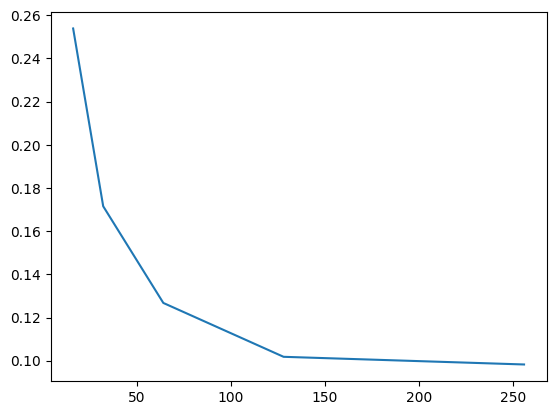

In [10]:
from matplotlib import pyplot as plt
plt.plot(np.array(list(acc_dict.keys())), 1-np.array(list(acc_dict.values())))

In [11]:
model.sampler

'ancestral'